In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [5]:
# import tensorflow as tf

# tf.compat.v1.enable_eager_execution()

In [6]:
import malaya_speech
import tensorflow as tf
from malaya_speech.train.model import fastsplit, fastspeech, sepformer, fastvc
import malaya_speech.augmentation.waveform as augmentation
import numpy as np






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [7]:
from glob import glob

wavs = glob('../speech/example-speaker/*.wav')
len(wavs)

8

In [26]:
import random

sr = 22050
speakers_size = 4

# noise = malaya_speech.load('noise.wav', sr = sr)[0]

def read_wav(f):
    return malaya_speech.load(f, sr = sr)


def random_sampling(s, length):
    return augmentation.random_sampling(s, sr = sr, length = length)

def to_mel(y):
    mel = malaya_speech.featurization.universal_mel(y)
    mel[mel <= np.log(1e-2)] = np.log(1e-2)
    return mel

def combine_speakers(files, n = 5, limit = 4):
    w_samples = random.sample(files, n)
    w_samples = [read_wav(f)[0] for f in w_samples]
    w_lens = [len(w) / sr for w in w_samples]
    w_lens = int(min(min(w_lens) * 1000, random.randint(2000, 10000)))
    w_samples = [random_sampling(w, length = w_lens) for w in w_samples]
    y = [w_samples[0]]
    left = w_samples[0].copy()

    combined = None

    for i in range(1, n):
        right = w_samples[i].copy()
        overlap = random.uniform(0.98, 1.0)
        print(i, overlap)
        len_overlap = int(overlap * len(right))
        minus = len(left) - len_overlap
        if minus < 0:
            minus = 0
        padded_right = np.pad(right, (minus, 0))
        left = np.pad(left, (0, len(padded_right) - len(left)))

        left = left + padded_right

        if i >= (limit - 1):
            if combined is None:
                combined = padded_right
            else:
                combined = np.pad(
                    combined, (0, len(padded_right) - len(combined))
                )
                combined += padded_right

        else:
            y.append(padded_right)

    if combined is not None:
        y.append(combined)
        
    maxs = [max(left)]
    for i in range(len(y)):
        if len(y[i]) != len(left):
            y[i] = np.pad(y[i], (0, len(left) - len(y[i])))
            maxs.append(max(y[i]))
            
    max_amp = max(maxs)
    mix_scaling = 1 / max_amp * 0.95
    left = left * mix_scaling
    
    for i in range(len(y)):
        y[i] = y[i] * mix_scaling

#     for i in range(len(y)):
#         if len(y[i]) != len(left):
#             y[i] = np.pad(y[i], (0, len(left) - len(y[i])))
#             y[i] = y[i] / np.max(np.abs(y[i]))

#     left = left / np.max(np.abs(left))
    return left, y

# y, _ = malaya_speech.load('../speech/example-speaker/husein-zolkepli.wav')
# y = np.expand_dims(y, 0).astype(np.float32)
# y.shape

In [27]:
left, y = combine_speakers(wavs, 6)
len(left) / sr, len(y)

1 0.9836447938165628
2 0.998723201505409
3 0.9817389919613754
4 0.9827268082137945
5 0.9811123182447715


(3.082721088435374, 4)

In [28]:
def to_mel(y):
    mel = malaya_speech.featurization.universal_mel(y)
    mel[mel <= np.log(1e-2)] = np.log(1e-2)
    return mel

In [29]:
left_mel = to_mel(left)
y_mel = [to_mel(i) for i in y]

In [30]:
import matplotlib.pyplot as plt

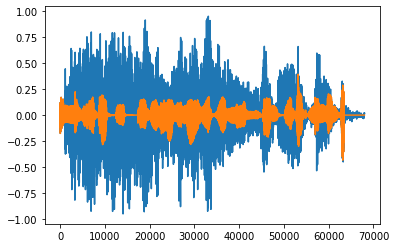

In [38]:
plt.plot(left)
plt.plot(y[0])

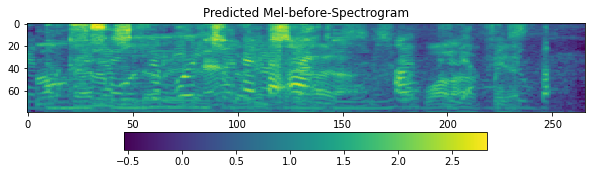

In [34]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(left_mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

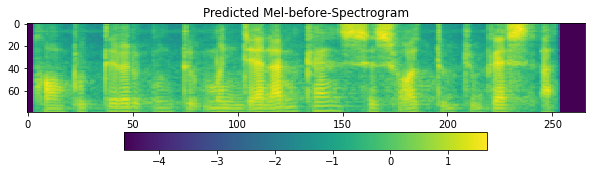

In [36]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(y_mel[1]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [32]:
config = malaya_speech.config.fastspeech_config
dim = 256
config['encoder_hidden_size'] = dim
config['decoder_hidden_size'] = dim
config['encoder_num_hidden_layers'] = 4
config['encoder_num_attention_heads'] = 4
config = fastspeech.Config(vocab_size = 1, **config)

In [10]:
transformer = lambda: sepformer.Encoder_FastSpeech(config.encoder_self_attention_params)
decoder = lambda: fastvc.Decoder(config.decoder_self_attention_params)

In [11]:
model = sepformer.Model_Mel(transformer, transformer, decoder)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
X = tf.placeholder(tf.float32, [None, None, 80])
len_X = tf.placeholder(tf.int32, [None])
logits = model(X, len_X)
logits

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


<tf.Tensor 'sepformer/concat:0' shape=(4, ?, ?, 80) dtype=float32>

In [13]:
Y = tf.placeholder(tf.float32, [None, speakers_size, None, 80])

In [14]:
outputs = tf.transpose(logits, [1, 2, 0, 3])
outputs

<tf.Tensor 'transpose:0' shape=(?, ?, 4, 80) dtype=float32>

In [15]:
loss, abs_set = fastsplit.calculate_loss(Y, outputs, len_X, C = speakers_size, return_set = True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



NameError: name 'n_output' is not defined

In [ ]:
# X = tf.convert_to_tensor(np.expand_dims([left], axis = -1).astype(np.float32))
# logits = model(X)

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
l = sess.run(logits, feed_dict = {X: [left_mel], len_X: [len(left_mel)]})
l.shape

In [ ]:
sess.run(loss, feed_dict = {X: [left_mel], len_X: [len(left_mel)], Y: [y_mel]})

In [ ]:
saver = tf.train.Saver()

In [ ]:
saver.save(sess, 'test/model.ckpt')

In [ ]:
!ls -lh test

In [ ]:
!rm -rf test